In [2]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Hit:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:3 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease               
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease             
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
80 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
xvfb is already the newest version (2:1.20.13-1ubunt

In [3]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [4]:
seed = 543 
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [41]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

!pip freeze

In [7]:
print("observation_space:",env.observation_space)
print("action_space:",env.action_space)
#env.step(action): State,reward,done,_

observation_space: Box(-inf, inf, (8,), float32)
action_space: Discrete(4)


In [6]:
#Q
class State_Action_Function(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc=nn.Sequential(
            nn.Linear(8,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,4)
        )

    def forward(self, x):
        return self.fc(x)

In [8]:
#memory,store experinces
class Memory(object):
    def __init__(self,max_size):
        self.memory=[]
        self.max_size=max_size
        self.pointer=0
    def append_(self,transition):
        #transition:([s1,s2,...],action a,reward r,[s_t_1...],done=0/1)
        if(self.pointer==self.max_size):
            self.memory.pop(0)
            self.memory.append(transition)
        else:
            self.memory.append(transition)
            self.pointer+=1
    def sample(self,batch_size=64):
        state_t=[]
        action=[]
        reward=[]
        state_t_1=[]
        done=[]
        for i in range(batch_size):
            index=random.randint(0,len(self.memory)-1)
            s_t,a,r,s_t_1,d=self.memory[index]
            state_t.append(s_t)
            action.append([a])
            reward.append([r])
            state_t_1.append(s_t_1)
            done.append([d])
        return torch.tensor(state_t),torch.LongTensor(action),torch.tensor(reward),torch.tensor(state_t_1),torch.LongTensor(done)

In [42]:
class Agent(object):
    def __init__(self):
        #policy net
        self.net=State_Action_Function().to('cuda')
        #target net
        self.target_net=State_Action_Function().to('cuda')
        #memory
        self.memory=Memory(10000)
        #hyper-prameters
        self.epochs=1000
        self.epsilon=1
        self.epsilon_decay=0.995
        self.epsilon_min=0.05
        self.discounted_rate=0.99
        self.update=4
        self.batch_size=64
        self.lr=0.0005
        
        self.scores=[]
        
    #ε-greedy
    def select_action(self,state,epsilon):
        state=state.to('cuda')
        prob=[epsilon/4]*4
        action=self.net(state).argmax()
        prob[action.detach().item()]+=1-epsilon
        return Categorical(torch.tensor(prob)).sample().item()
    
    #play game with policy net and εfixed as 0.1
    def play(self):
        global env
        
        state=env.reset()
        state=torch.tensor(state)
        Q=0.0
        done=False
       
        while done==False:
            action=self.select_action(state,0.1)
            state,reward,done,_=env.step(action)
            state=torch.tensor(state)
            Q=Q+self.discounted_rate*reward
        return Q
    
    #training
    def learn(self):
        global env
        optimizer=optim.Adam(self.net.parameters(),lr=self.lr)
        criterion=nn.MSELoss()
        scores_window=[]
        window_size=5
        for i in range(self.epochs):
            state_t=env.reset()
            state_t=torch.tensor(state_t)
            done=False
            count=0
            score=0.0
            self.net.train()
            while done==False:
                count+=1
                action=self.select_action(state_t,self.epsilon)
                state_t_1,reward,done,_=env.step(action)
                score+=reward
                state_t_1=torch.tensor(state_t_1)
                self.memory.append_((state_t.tolist(),action,reward,state_t_1.tolist(),done))
                state_t=state_t_1
                s_t_s,acs,rs,s_t_1s,ds=self.memory.sample(self.batch_size)
                
                Q_est=self.net(s_t_s.to('cuda')).cpu()
                
                Q_est=torch.gather(Q_est,1,acs)
                
                y,_=torch.max(self.target_net(s_t_1s.to('cuda')),dim=1)
                y=torch.unsqueeze(y,dim=1).cpu()
               
                y=rs+self.discounted_rate*(1-ds)*y
                
                loss=criterion(y.double(),Q_est.double())
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                if count%self.update==0:
                    self.target_net.load_state_dict(self.net.state_dict())
            env.close()
            
            self.scores.append(score)
            
            #epsilon decay
            if self.epsilon>self.epsilon_min:
                self.epsilon*=self.epsilon_decay
                
            if len(scores_window)==window_size:
                scores_window.pop(0)
                scores_window.append(score)
            else:
                scores_window.append(score)
                
            #save model is the average of the last five scores surpass 180
            if sum(scores_window)/window_size>180:
                print("save model")
                torch.save(self.net.state_dict(), "model.pt")
            print("epoch:",i+1,"score:",score)
            
                
A=Agent()
A.learn()

epoch: 1 score: -115.96999715094047
epoch: 2 score: -90.39001051077261
epoch: 3 score: -256.8683583312337
epoch: 4 score: -386.7432310991994
epoch: 5 score: -143.02648277566064
epoch: 6 score: -126.30599649713056
epoch: 7 score: -422.46550190585253
epoch: 8 score: -111.42657994703596
epoch: 9 score: -132.88190084731508
epoch: 10 score: -91.00000051048008
epoch: 11 score: -217.23122961125858
epoch: 12 score: -263.3242135550039
epoch: 13 score: -139.51198586081028
epoch: 14 score: -119.0353428395285
epoch: 15 score: -154.64558581048544
epoch: 16 score: -246.06948572049095
epoch: 17 score: -95.80733958717985
epoch: 18 score: -208.99730836214
epoch: 19 score: -123.69822017652933
epoch: 20 score: -81.40105849860737
epoch: 21 score: -175.11636890509698
epoch: 22 score: -92.7664162352716
epoch: 23 score: -84.78965145906061
epoch: 24 score: -110.70601122620302
epoch: 25 score: -58.49995015260732
epoch: 26 score: -83.19493439191365
epoch: 27 score: -171.86662091707416
epoch: 28 score: -291.4576

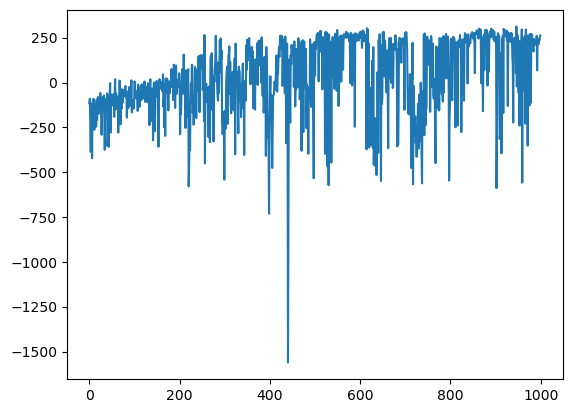

In [45]:
a=range(0,1000)
plt.plot(A.scores[:1000])
plt.show()

In [43]:
#play games with the trained policy net
env.reset()
for i in range(10):
    print(A.play())

217.4343489317327
201.58972169098476
81.57838097438709
194.65321865273143
267.837471186
210.92380652255196
255.1346729216603
245.40225454416398
-151.68947847498902
237.8315510312011
